# Support Vector Machines (SVM)



In [2]:
#Always include important imports at the top
import numpy as np #for linear algebra functions
import pandas as pd #for data processing the CSV
import time

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#sklearn imports
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report #for nice end formatting
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.decomposition import PCA

#importing the dataset as a dataframe
df = pd.read_csv("taxis.csv").dropna()

## Pre-Processing
Before we can run SVM, we need to pre-process the data and encode labels. We will do this using sklearn's preprocessing package.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6342 entries, 0 to 6432
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pickup           6342 non-null   object 
 1   dropoff          6342 non-null   object 
 2   passengers       6342 non-null   int64  
 3   distance         6342 non-null   float64
 4   fare             6342 non-null   float64
 5   tip              6342 non-null   float64
 6   tolls            6342 non-null   float64
 7   total            6342 non-null   float64
 8   color            6342 non-null   object 
 9   payment          6342 non-null   object 
 10  pickup_zone      6342 non-null   object 
 11  dropoff_zone     6342 non-null   object 
 12  pickup_borough   6342 non-null   object 
 13  dropoff_borough  6342 non-null   object 
dtypes: float64(5), int64(1), object(8)
memory usage: 743.2+ KB


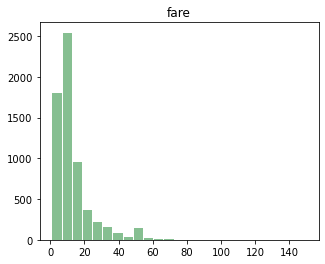

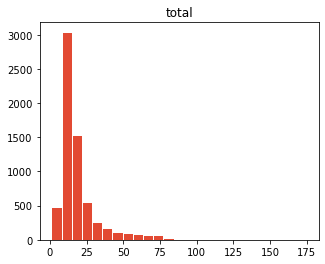

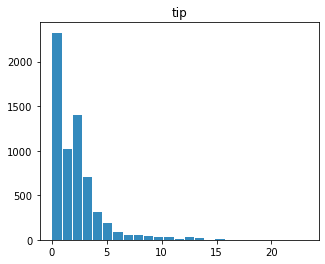

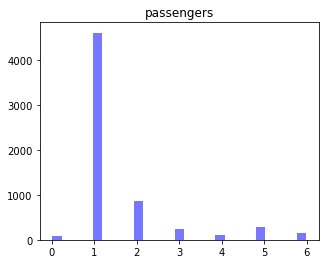

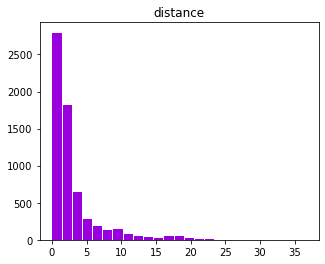

In [3]:
ax = df.hist(column='fare', bins=25, grid=False, figsize=(5,4), color='#86bf91', zorder=2, rwidth=0.9)
bx = df.hist(column='total', bins=25, grid=False, figsize=(5,4), color="#e24a33", zorder=2, rwidth=0.9)
cx = df.hist(column='tip', bins=25, grid=False, figsize=(5,4), color="#348abd", zorder=2, rwidth=0.9)
dx = df.hist(column='passengers', bins=25, grid=False, figsize=(5,4), color="#77f", zorder=2, rwidth=0.9)
ex = df.hist(column='distance', bins=25, grid=False, figsize=(5,4), color="#90d", zorder=2, rwidth=0.9)

In [4]:
# Investigate fare
df['fare'].value_counts()

7.50      348
6.00      344
6.50      322
5.00      309
5.50      308
         ... 
63.53       1
42.82       1
150.00      1
58.50       1
26.32       1
Name: fare, Length: 206, dtype: int64

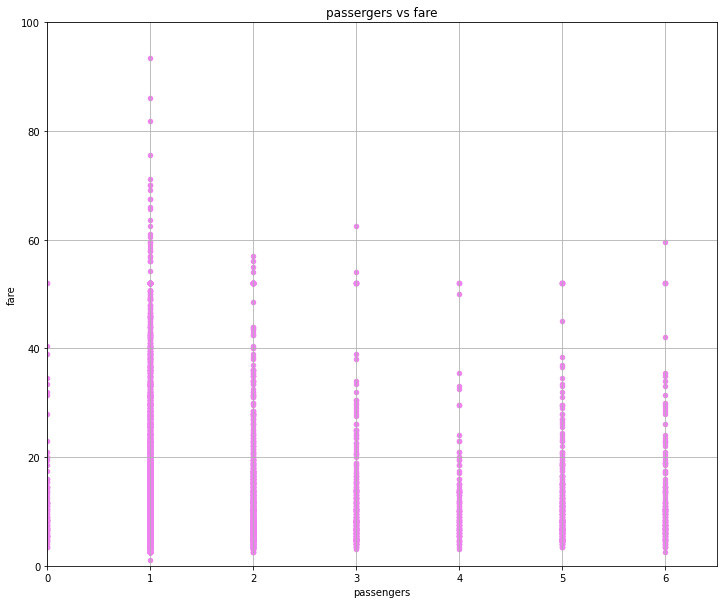

In [14]:
df.plot(kind='scatter',x= 'passengers',y='fare',color='violet',figsize = (12,10), grid = True)
plt.gca().set(xlim=(0, 6.5), ylim=(0, 100) )
plt.xlabel('passengers')
plt.ylabel('fare')
plt.title('passergers vs fare')
plt.show()

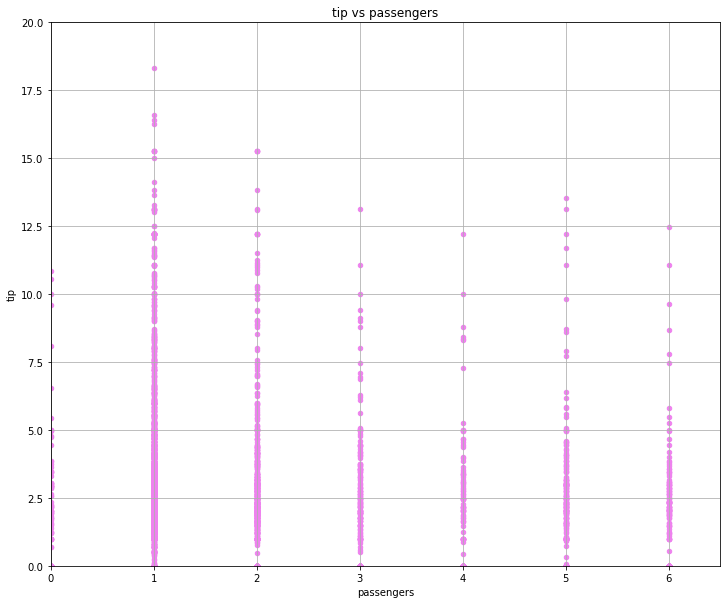

In [15]:
df.plot(kind='scatter',x= 'passengers',y='tip',color='violet',figsize = (12,10), grid = True)
plt.gca().set(xlim=(0, 6.5), ylim=(0, 20) )
plt.xlabel('passengers')
plt.ylabel('tip')
plt.title('tip vs passengers')
plt.show()

In [4]:

#Replacing credit card / cash in the target variable (payment) with 0/1
df['payment'] = df['payment'].map({'credit card':0, 'cash':1})

In [5]:
# Investigate tip
df['tip'].value_counts()

0.00    2245
1.00     312
2.00     211
2.16      89
1.86      79
        ... 
7.94       1
0.89       1
9.36       1
7.95       1
7.70       1
Name: tip, Length: 481, dtype: int64

In [3]:
#Dropping variables listed above that are correlated
df_final = df.drop(['pickup_zone','dropoff_zone','pickup_borough','dropoff_borough'], axis=1)
#Confirm those variables were sucessfully dropped
df_final

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,0
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,1
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,0
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,0
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,0
...,...,...,...,...,...,...,...,...,...,...
6428,2019-03-31 09:51:53,2019-03-31 09:55:27,1,0.75,4.5,1.06,0.0,6.36,green,0
6429,2019-03-31 17:38:00,2019-03-31 18:34:23,1,18.74,58.0,0.00,0.0,58.80,green,0
6430,2019-03-23 22:55:18,2019-03-23 23:14:25,1,4.14,16.0,0.00,0.0,17.30,green,1
6431,2019-03-04 10:09:25,2019-03-04 10:14:29,1,1.12,6.0,0.00,0.0,6.80,green,0


In [10]:
#Create a function which takes the dataset as input and ouputs the processed dataset
def preprocessor(df):
    res_df = df.copy()
    le = preprocessing.LabelEncoder()
    
    res_df['pickup'] = le.fit_transform(res_df['pickup'])
    res_df['dropoff'] = le.fit_transform(res_df['dropoff'])
    res_df['passengers'] = le.fit_transform(res_df['passengers'])
    res_df['distance'] = le.fit_transform(res_df['distance'])
    res_df['fare'] = le.fit_transform(res_df['fare'])
    res_df['tip'] = le.fit_transform(res_df['tip'])
    res_df['color'] = le.fit_transform(res_df['color'])
    res_df['tolls'] = le.fit_transform(res_df['tolls'])
    res_df['total'] = le.fit_transform(res_df['total'])
    return res_df


#Run the function on the desired dataset
encoded_df = preprocessor(df_final)

The next step is to select which features we want to use with SVM and standardize them.

In [11]:
#Selecting features
X = encoded_df.drop(['payment'],axis =1)
y = encoded_df['payment']
y

0       0
1       1
2       0
3       0
4       0
       ..
6428    0
6429    0
6430    1
6431    0
6432    0
Name: payment, Length: 6342, dtype: int64

In [12]:
#Standardizing features
sc = StandardScaler()
X = sc.fit_transform(X)

#Confirm the new mean and standard deviation of the dataset
mean = np.mean(X, axis=0)
print('Mean: (%d, %d)' % (mean[0], mean[1]))
standard_deviation = np.std(X, axis=0)
print('Standard deviation: (%d, %d)' % (standard_deviation[0], standard_deviation[1]))

Mean: (0, 0)
Standard deviation: (1, 1)


## Split into Train and Test data
To apply SVM, the data must be split into "training" and "test" data.

In [13]:
#Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 40)

In [14]:
start = time.time()

#Instantiate the model
svc_default = SVC() # Default hyperparameters
#Fit the model with data
svc_default.fit(X_train,y_train)

end = time.time()
svm_time = end-start
print('Train Time (seconds) of Default SVM:',svm_time)

y_pred_default = svc_default.predict(X_test)

print('Default Accuracy Score:',accuracy_score(y_test,y_pred_default))

Train Time (seconds) of Default SVM: 0.1226811408996582
Default Accuracy Score: 0.9293820933165196


Next, we want to compare the results using different kernels

In [15]:
start = time.time()

#Linear Kernel
svc_linear = SVC(kernel = 'linear')
#Fit the model with data
svc_linear.fit(X_train,y_train)

end = time.time()
svm_time = end-start
print('Train Time (seconds) of SVM linear Kernel:',svm_time)

y_pred_linear = svc_linear.predict(X_test)

print('Linear Accuracy Score:',accuracy_score(y_test,y_pred_linear))

Train Time (seconds) of SVM linear Kernel: 0.07117104530334473
Linear Accuracy Score: 0.9281210592686002


In [16]:
start = time.time()

#Polynomial Kernel
svc_poly = SVC(kernel = 'poly')
#Fit the model with data
svc_poly.fit(X_train,y_train)

end = time.time()
svm_time = end-start
print('Train Time (seconds) of SVM with polynomial kernel:',svm_time)

y_pred_poly = svc_poly.predict(X_test)

print('Polynomial Accuracy Score:',accuracy_score(y_test,y_pred_poly))

Train Time (seconds) of SVM with polynomial kernel: 0.13207316398620605
Polynomial Accuracy Score: 0.914249684741488


In [17]:
start = time.time()

#Radial Kernel
svc_rad = SVC(kernel = 'rbf', probability = True)
#Fit the model with data
svc_rad.fit(X_train,y_train)

end = time.time()
svm_time = end-start
print('Train Time (seconds) of SVM with radial kernel:',svm_time)

y_pred_rad = svc_rad.predict(X_test)

Train Time (seconds) of SVM with radial kernel: 0.582301139831543


# Performance Analysis
The next step is to conduct a performance analysis of the model. Because the radial kernel had the highest accuracy in the shortest time, we will only conduct performance analysis using the radial kernel as a predictor. We do this by examining the confusion matrix and the Receiver Operating Characteristic (ROC) curve. 

In [18]:
print("Accuracy:", accuracy_score(y_test,y_pred_rad))

Accuracy: 0.9293820933165196


Text(0.5, 257.44, 'Predicted label')

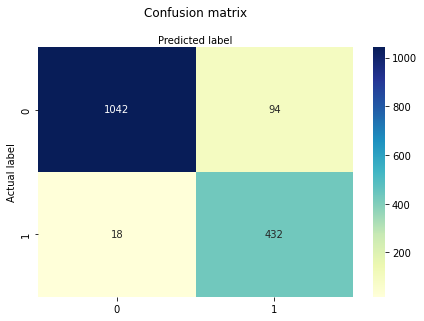

In [19]:
#Creating the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_rad)
class_names=[0,1] # name  of classes

#Creating the figure
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#Adding the heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [20]:
#Print a nicely formatted report
classify_svc = classification_report(y_test, y_pred_rad)
print("\nClassification Report")
print(classify_svc)


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1136
           1       0.82      0.96      0.89       450

    accuracy                           0.93      1586
   macro avg       0.90      0.94      0.92      1586
weighted avg       0.94      0.93      0.93      1586



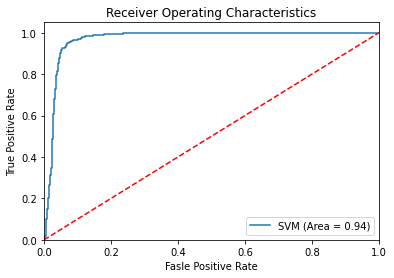

In [21]:
#Plot the ROC curve
svc_roc_auc = roc_auc_score(y_test,y_pred_rad)
fpr, tpr, thresholds = roc_curve(y_test,svc_rad.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='SVM (Area = %0.2f)' % svc_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('Fasle Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics')
plt.legend(loc="lower right")
plt.show()

# Using PCA

In [22]:
# Make an instance of the model and specify that 90% of the variance needs to be retained
n = 90
pca = PCA(n/100)

# Fit the PCA on the training set
pca.fit(X_train)

print('To retain',n,'% of the variation, we needed',pca.n_components_,'components')

To retain 90 % of the variation, we needed 5 components


In [23]:
# Applying transformation to both Training and Test set

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [24]:
# SVM with PCA

start = time.time()

svc_pca = SVC(kernel = 'rbf', probability = True)
svc_pca.fit(X_train_pca, y_train)

end = time.time()
svm_time_pca = end-start
print('Train Time (seconds) of SVM with PCA:',svm_time_pca)

y_pred_svc_pca = svc_pca.predict(X_test_pca)

Train Time (seconds) of SVM with PCA: 0.5437479019165039


In [25]:
print("Accuracy:", accuracy_score(y_test,y_pred_svc_pca))

Accuracy: 0.9293820933165196


Text(0.5, 257.44, 'Predicted label')

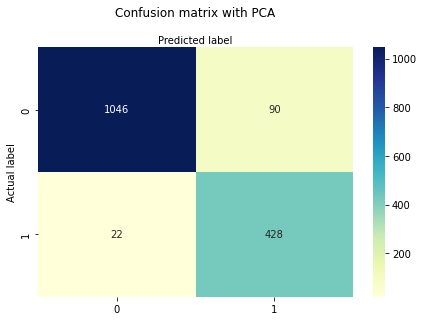

In [26]:
#Creating the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_svc_pca)
class_names=[0,1] # name  of classes

#Creating the figure
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#Adding the heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix with PCA', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [27]:
classify_svc_pca = classification_report(y_test, y_pred_svc_pca)
print("\nClassification Report with PCA")
print(classify_svc_pca)


Classification Report with PCA
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1136
           1       0.83      0.95      0.88       450

    accuracy                           0.93      1586
   macro avg       0.90      0.94      0.92      1586
weighted avg       0.94      0.93      0.93      1586



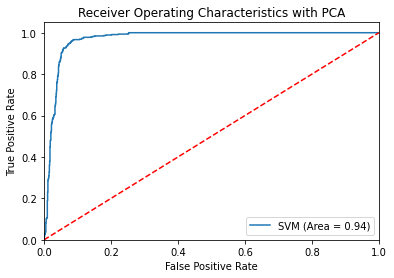

In [28]:
svc_roc_auc_pca = roc_auc_score(y_test,y_pred_svc_pca)
fpr, tpr, thresholds = roc_curve(y_test,svc_pca.predict_proba(X_test_pca)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='SVM (Area = %0.2f)' % svc_roc_auc_pca)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics with PCA')
plt.legend(loc="lower right")
plt.show()

Decission Tree:
Train Time (seconds) of Default SVM: 0.1226811408996582
Default Accuracy Score: 0.9293820933165196

Train Time (seconds) of SVM linear Kernel: 0.07117104530334473
Linear Accuracy Score: 0.9281210592686002

Train Time (seconds) of SVM with polynomial kernel: 0.13207316398620605
Polynomial Accuracy Score: 0.914249684741488

Train Time (seconds) of SVM with radial kernel: 0.582301139831543
Radial kernel Accuracy: 0.9293820933165196

USING PCA:
Train Time (seconds) of SVM with PCA: 0.5437479019165039
Accuracy: 0.9293820933165196